{[Click here to read this notebook in Google Colab](https://colab.research.google.com/drive/1NmPCcEM2zuxb6-D9p3DYlp1v7U1WHaBE)}

<head><link rel = "stylesheet" href = "https://drive.google.com/uc?id=1zYOH-_Mb9jOjRbQmghdhsmZ2g6xAwakk"></head>

<table class = "header"><tr>
    <th align = "left">EPAT Batch 45 | Machine Learning, May 2020</th>
    <th align = "right">Written by: Gaston Solari Loudet</th>
</tr></table>

### Planar data classification with logistic deep neural network.

Welcome to your week 3 programming assignment. It's time to build your first neural network, which will have a hidden layer. You will see a big difference between this model and the one you implemented using logistic regression.

You will learn to:
* Implement a 2-class classification neural network with a single hidden layer.
* Use units with a non-linear activation function, such as "$tanh(z)$".
* Compute the cross entropy loss 
* Implement forward and backward propagation

Let's first import all the packages that you will need during this assignment.
* [``numpy``]("https://www.numpy.org"): is the fundamental package for scientific computing with Python.
* [``matplotlib``]("http://matplotlib.org"): is a famous library to plot graphs in Python.
* [``sklearn``]("http://scikit-learn.org/stable/"): provides simple and efficient tools for data mining and data analysis.
* [``planar_utils``]("https://github.com/andersy005/deep-learning-specialization-coursera/blob/master/01-Neural-Networks-and-Deep-Learning/week3/Programming-Assignments/planar_utils.py"): provides various useful functions used in this document.

In [4]:
import os, urllib.request, numpy, matplotlib.pyplot, sklearn, planar_utils
matplotlib.pyplot.style.use("https://drive.google.com/uc?id=1TawPXELPzNlySaOx3HT67A-wHwRxuWjQ")
from numpy import dot, log, exp, tanh

#### Dataset

First, let's get the dataset you will work on. The following code will load a "flower" 2-class dataset into arrays "$𝕏$" and "$𝕪$". Visualize the dataset. The data looks like a "flower" with some red ("$y_{s} = 0$") and some blue ("$y_{s} = 1$") sample points. Our goal is to build a model to fit this data. Notice that "$𝕏$" interprets the role of "training data" and "$𝕪$" acts as the outcome array.

Samples: 400 | Feature array shape: (2, 400) | Label array shape: (400,)


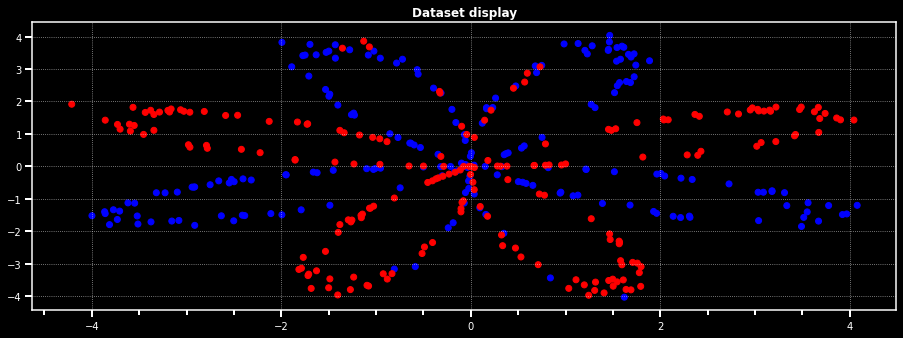

In [10]:
# Import dataset to numpy:
X_data, y_data = planar_utils.load_planar_dataset()    ;  y_data = y_data.squeeze()
print(f"Samples: {len(y_data)} | Feature array shape: {X_data.shape} | Label array shape: {y_data.shape}")
# Draw dataset points.
Figure_1 = matplotlib.pyplot.figure()  ;  Figure_1.add_axes([0.1, 0.1, 0.8, 0.8]);
Figure_1.axes[0].scatter(X_data[0, :], X_data[1, :], c = y_data, cmap = matplotlib.pyplot.cm.bwr);
Figure_1.axes[0].set_title(label = "Dataset display", fontweight = "bold");

#### Simple logistic regression

Before building a full neural network, we should first see how last week's logistic regression model performs on this problem. One can use ``sklearn``'s built-in functions to do that. Run the code below to train a logistic regression classifier on the dataset. Let's then plot the "decision boundary" of the model. It shall be able to somewhat separate the color points between areas.

Accuracy of logistic regression: 47.00%
(Percentage of correctly predicted datapoints)


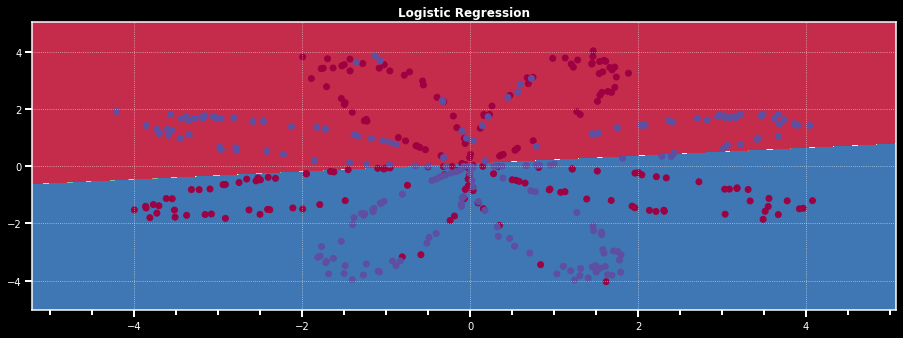

In [19]:
# Train the logistic regression classifier
Model_1 = sklearn.linear_model.LogisticRegressionCV()
Model_1.fit(X_data.T, y_data.T)
# Plot the decision boundary for logistic regression.
matplotlib.pyplot.sca(Figure_1.axes[0])
planar_utils.plot_decision_boundary(lambda x: Model_1.predict(x), X_data, y_data)
# Set plot properties.
Figure_1.axes[0].set_xlabel("")   ;    Figure_1.axes[0].set_ylabel("")
Figure_1.axes[0].set_title("Logistic Regression", fontweight = "bold")
# Predict and then calculate accuracy
y_pred_1 = Model_1.predict(X_data.T)
n_1s = numpy.dot(y_data, y_pred_1)          # Guessed 1s
n_0s = numpy.dot(1 - y_data, 1 - y_pred_1)  # Guessed 0s
R_train_1 = (n_1s + n_0s)/len(y_data)

print("Accuracy of logistic regression: %.2f%%" % float(100*R_train_1))
print("(Percentage of correctly predicted datapoints)")

Notice that the <u>dataset is not linearly separable</u>. Thus logistic regression doesn't perform well (47%). A deep neural network will do better. Let's try it!

<hr>

#### Deep neural network model

We are going to build a shallow neural network model with one "hidden" layer of neurons.

Recall the structure of training sample arrays.
<ul> <li>We've got a sample (training) matrix "$𝕏$".</li>
     <ul><li>Each column corresponds to a single sample point "$𝕩_{s}$".</li>
         <li>Each row of such column vector is the coordinate "$x_{(v;\:s)}$".
         <br>As dataset is planar: "$ 𝕩_{(s)} = (x_{(1;\:s)}; x_{(2;\:s)}) $".</li></ul>
     <li>We've got an outcome array "$𝕪$" with point colors.
     <br>Its elements can either be 1 (blue) or 0 (red).</li>
     <li>We've got a total of "$S$" sample points to train on.
     <br>(Equal to the length of arrays "$𝕏$" and "$𝕪$").</li></ul>

The neural network will acquire the following structure:

<center><img width = "100%" src = "https://drive.google.com/uc?id=16p8O3WEfro002bAL69TRSj2igt2pb38i"></img></center>

There are three layers, each one being labelled with index "$l$".
<br>This index can go from 0 to "$L$". In this case, "$L = 2$".
<br>So we have:
<ul> <li>The input layer, "$l = 0$".
<ul> <li>The nodes are "false neurons": just gateways for the input variables.
</li><li>Therefore, its activation function will always be just "$f(z) = z$".
</li><li>It's weights and bias will always be 0s and 1s and will never change.  <br>(We'll come back to this later)</li></ul>
</li><li>One hidden layer, "$l = 1$".
<ul> <li>It will be formed by a quantity of "$N_{l} = N_{1}$" neurons.
</li><li>Each neuron "$n$" will feed on the outputs from layer "$l = 0$".
</li><li>In this particular case, these will be the input variables themselves.
<br>(With more than one hidden layer, these would be the previous layers' activation values)</li></ul>
</li><li>The output layer, "$l = 2$".
<ul> <li>Formed by a single node/neuron. Then "$N_{L} = N_{2} = 1$", always.
</li><li>The neuron will feed on the activation values from layer "$l - 1 = 1$".</li></ul></li></ul>
Notice that:
<ul> <li>"$L$" is the index of the final layer of the single output neuron.
</li><li>The total amount of layers on the model, is always "$L + 1$".
</li><li>We can have a array "$ℕ$" storing the number of neurons for each layer:
<br>"$ ℕ = (N_{0};\:N_{1};\:...;\:N_{L}) $"... in this case: "$ℕ = (2;\:4;\:1)$"</li></ul>

<br>Recall the forward propagation procedure from logistic regression exercises.
<br>Let's take one generic neuron "$n$" from layer "$l$" while training on a sample point "$s$"
<br>(Mind that:  "$0 < l < L$",  "$1 < n < N_{l}$",  "$0 < s < S$")<br>

<center><img width = "400px" src = "https://drive.google.com/uc?id=1-SLqn04DaFw7nMAGzEo7zfikfgEKFUzo"></img></center>


## <ul><font color = "yellow" size = "4"><b><u>Forward propagation</u></b></font> ##

<ul>For a certain sample training point number "$s$", the procedure is:

<ol> <li>Feed the neuron on the activation outputs from previous layer "$l - 1$" as input variables:

$$ 𝕒_{(l-1;\:s)} =
 (a_{(l - 1;\:1;\:s)}; a_{(l - 1;\:2;\:s)};\:...;a_{(l - 1;\:N(l - 1);\:s)}) $$ 

</li><li>Find the linear combination using neuron's weights "$𝕨_{(h;\:n)} = (w_{(l;\:n;\:1)}; w_{(l;\:n;\:2)}; ...; w_{(l;\:n;\:N_{l - 1})})$" and bias "$b_{(l;\:n)}$":

$$ z_{(l;\:n;\:s)} = b_{(l;\:n)} + 𝕨_{(l;\:n)} \cdot 𝕒_{(l-1;\:s)} $$

</li><li>Calculate the new activation value with the neuron's activation function "$f_{(l;\:n)}(z)$":

$$ a_{(l;\:n;\:s)} = f_{l;\:n}(z_{(l;\:n;\:s)}) $$

</li><li>Repeat steps 1 to 3 but for next neuron "$n + 1$" until all neurons are covered ("$n = N_{l}$").
</li><li>Repeat steps 1 to 4 but for the next layer "$l + 1$" until all layers are covered ("$l = L$")
</li></ol>

<br><b><u>Notice that</u></b>: if all of the activation functions from layer "$l$" are the same: "$f_{(l;\:n)}(z) = f_{l}(z)$"...
<br>...then neuron's "$n$" index can be deleted and steps from 1 to 4 can be written as a matrix equation:

$$ 𝕒_{(l;\:s)} = f_{l}(𝕫_{(l;\:s)}) = f_{l}(𝕓_{l} + 𝕎_{l} \cdot 𝕒_{(l - 1;\:s)}) $$

<br>Finally, sample's "$s$" index can be also deleted if we consider each column vector "$𝕒_{(l;\:s)}$" and "$𝕫_{(l;\:s)}$" to be sample columns in a couple of larger matrices "$𝔸_{l}$" and "$ℤ_{l}$" respectively. Like that, we arrive to the "<b><u>forward propagation equation</u></b>":

<font color = "yellow">
$$ 𝔸_{l} = f_{l}(ℤ_{l}) = f_{l}(𝕓_{l} + 𝕎_{l} \cdot 𝔸_{l - 1}) $$</font>

<b><u>Notice that</u></b> for "$l = 0$" → → → "$𝔸_{0} = 𝕏$"!!

In [0]:
# First, define neural network structure with a list of dicts like this:
v, n_samples = X_2D_train.shape
NN = [ {"nodes": v, "weights": 1,    "bias": 0,    "function": None},
       {"nodes": 4, "weights": None, "bias": None, "function": "tanh"},
       {"nodes": 1, "weights": None, "bias": None, "function": "sigmoid"} ]

# Print subindex upper bounds:
print("(S) Number of training samples:  %d" % n_samples)
print("    Amount of hidden layers:     %d" % len(NN[1:-1]))
print("(N) Array of neurons per layer:  %s" % ([N["nodes"] for N in NN[1: ]],))
print("    Variables from prev layer:   %s" % ([N["nodes"] for N in NN[:-1]],))

(S) Number of training samples:  400
    Amount of hidden layers:     1
(N) Array of neurons per layer:  [4, 1]
    Variables from prev layer:   [2, 4]


<ul><b><u>Exercise</u></b>: Initialize "$𝕎_{l}$" and "$𝕓_{l}$" parameters for all layers "$l$".
<ul><li>Make sure your parameters' sizes are right.
<br>Refer to the neural network figure above if needed.
</li><li>You will initialize the weights matrices with random values. 
<br>Use "<code>numpy.random.randn(a,b)/100</code>" to initialize a matrix of shape "<code>(a,b)</code>" with small random values.
</li><li>You will initialize the bias vectors as zeros. 
<br>Use "<code>numpy.zeros((a,b))</code>" to initialize a matrix of shape "<code>(a,b)</code>" with zeros.</li></ul>

In [0]:
def NN_init(NN = [{"nodes": 0, "function": "identity"},
                  {"nodes": 1, "function": "sigmoid"}],
            X = numpy.array([[0, 0, 1, 1], [0, 1, 0, 1]])):
    """
    Initialize neural network weight matrices and bias vectors.
    Inputs: -> "X": Array with training samples.
            -> "NN": Neural network dict structure.
    Output: -> "NN": Same dict but with updated "weights" and "bias" values.
    """
    # Error check.
    if (type(NN) != list) or (len(NN) < 1) or (type(NN[0]) != dict):
        raise ValueError("Neural network has to be a list of dictionaries.")
    if (type(X) != numpy.ndarray) or (X.shape[1] < 2**X.shape[0]):
        raise ValueError("Sample matrix has to be a list of enough samples.")
    # Adapt dummy layer as gateway.
    NN[0]["nodes"] = X.shape[0]
    NN[0]["linear"] = X
    NN[0]["output"] = X #- X.min())/(X.max() - X.min())
    NN[0]["bias"] = numpy.zeros(shape = (NN[0]["nodes"], 1))
    NN[0]["weights"] = numpy.identity(n = NN[0]["nodes"])
    # Random matching.
    numpy.random.seed(6)

    # Loop over all layers in dict.
    for layer in range(1, len(NN)):
        if "nodes" not in NN[layer].keys():
            raise ValueError("Absent 'nodes' number in layer %d." % layer)
        else: # "rows = nodes", "columns = variables".
            NN[layer]["bias"] = numpy.zeros((NN[layer]["nodes"], 1))
            NN[layer]["weights"] = numpy.random.randn(NN[layer]["nodes"],
                                            NN[layer - 1]["nodes"])*0.01
    return NN

<ul><b><u>Cache</u></b>: It's the storage of the "$ℤ_{l}$" and "$𝔸_{l}$" matrices for future back-propagation.
<br>We are using the "<code>linear</code>" ("$ℤ$") and "<code>output</code>" ("$𝔸$") entries in the dict structure for this.
<br>Every time we forward-propagate, such results must be iteratively saved in such places.

In [0]:
def f_propagate(NN, X = numpy.array([[0, 0, 1, 1], [0, 1, 0, 1]])):
    """
    Initialize neural network weight matrices and bias vectors.
    Inputs: -> "NN": Neural network dict structure, already initialized.
    Output: -> "NN": Same dict but with updated "linear" and "output" values.
    """
    # Error check.
    if not(isinstance(NN, list) and (len(NN) > 1) and isinstance(NN[0], dict)):
        raise ValueError("Neural network has to be a list of dictionaries.")
    if not(isinstance(X, numpy.ndarray) or (X.shape[1] >= 2**X.shape[0])):
        raise ValueError("Sample matrix has to be a list of enough samples.")
    # Get input features/variables
    NN[0]["linear"] = X
    NN[0]["output"] = X #- X.min())/(X.max() - X.min())

    # Loop over all layers in dict.
    for layer in range(1, len(NN)):
        # Retrieve parameters and input variables.
        b = NN[layer]["bias"]
        W = NN[layer]["weights"]
        A = NN[layer - 1]["output"]
        # Weighted sum (linear comb) of previous outputs.
        Z = b + dot(W, A) # Cut/paste above        
        if "grads" not in NN[layer].keys():
            NN[layer]["grads"] = {}
        if "function" not in NN[layer].keys():
            raise ValueError("Absent act. 'function' in layer %d." % layer)
        # Activation function selector. CHANGE LAMBDAS BY DIRECT CALCULATIONS.
        else:
            f = NN[layer]["function"][0].lower()
            # identity, relu, tanh, sigmoid
            if f == "i":  A = Z ; dA = numpy.ones_like(A)
            if f == "r":  A = numpy.multiply(Z, Z > 0) ; dA = 1*(A > 0)
            if f == "t":  A = tanh(Z) ; dA = 1 - numpy.power(A, 2)
            if f == "s":  A = 1/(1 + exp(-Z)) ; dA = numpy.multiply(A, 1 - A)
        # Activation values.
        NN[layer]["linear"] = Z
        NN[layer]["output"] = A
        NN[layer]["grads"] = {"da/dz": dA}

    return NN

## <ul><font color = "yellow" size = "4"><b><u>Back propagation</u></b></font> ##

<ul>On this opportunity, we'll work with the most general case, where the cost function "$C$" could be anything.
<br>The chain rule will serve as our main weapon when finding the derivatives of it with respect to all neuron parameters.
<br>So we've got to work out:
<table>
 <tr><td width = "50"><font size = "5">$ \frac{\partial C}{\partial 𝕎_{l}} $
</td><td width = "12"><font size = "3">and
</td><td width = "32"><font size = "5">$ \frac{\partial C}{\partial 𝕓_{l}} $
</td><td width = "100"><font size = "3">...for "$1 < l < L$"</td>
<tr></table>

<br>

<table width = "820">
 <tr><td><font size = "3"><center>As the "forward propagation" name itself implies, the<br>calculated entities had a certain "forward" order...</center>
</td><td><font size = "3"><center>By intuition, the "back propagation" process would<br>have the gradients be calculated on the opposite lane:</center></td></tr>
 <tr><td><img src = "" width = "400px" height = "100px">
</td><td><img src = "" width = "400px" height = "100px"></tr>
</table>

<br>Let's start by following this backroad while computing the cost derivatives for the final output neuron.
<ul><table align = "left">
 <tr><td><font size = "5">$ \frac{\partial C}{\partial 𝔸_{L}} $</font>
</td><td><font size = "3">...this one depends on the chosen cost function "$C$", hence on the nature of the problem itself.</font></td>
<tr></table>

</ul><br><br><br><font size = "3">Next, by chain rule:</font>
<ul><table align = "left">
 <tr><td><font size = "5">$ \frac{\partial C}{\partial ℤ_{L}} = \frac{\partial C}{\partial 𝔸_{L}} \cdot \frac{\partial 𝔸_{L}}{\partial ℤ_{L}} $ </font>
</td><td><font size = "3">Now remember that "$ 𝔸_{L} = f_{L}(ℤ_{L}) $".
<br>...so the rightmost derivative is "$f_{L}'$"!</font>
</td><td><font size = "5">$ \rightarrow \frac{\partial C}{\partial ℤ_{L}} = \frac{\partial C}{\partial 𝔸_{L}} \cdot f_{L}' $ </font>
<tr></table>

</ul><br><br><br><font size = "3">Now, see that the path in the image forks because we've got to calculate gradients with respect to parameters "$𝕎_{L}$" and "$𝕓_{L}$".
<br>However, we've also got to differentiate with respect to "$𝔸_{L - 1}$" as well to continue the backpropagation trip:</font>
<ul><table align = "left">
 <tr><td>
</td><td><font size = "5"> $\nearrow \frac{\partial C}{\partial 𝕎_{L}} =
\frac{\partial C}{\partial ℤ_{L}} \cdot \frac{\partial ℤ_{L}}{\partial 𝕎_{L}} = \frac{\partial C}{\partial 𝔸_{L}} \cdot f_{L}' \cdot 𝔸_{L - 1}$</font></td><td></tr>
 <tr><td><font size = "3">Linear combination formula:<br>
"$ ℤ_{L} = 𝕓_{L} + 𝕎_{L} \cdot 𝔸_{L - 1} $".</font>
</td><td><font size = "5"> $\rightarrow \frac{\partial C}{\partial 𝕓_{L}} =
\frac{\partial C}{\partial ℤ_{L}} \cdot \frac{\partial ℤ_{L}}{\partial 𝕓_{L}} = \frac{\partial C}{\partial 𝔸_{L}} \cdot f_{L}'$</font></td><td></tr>
 <tr><td>
</td><td><font size = "5"> $\searrow \frac{\partial C}{\partial 𝔸_{L - 1}} =
\frac{\partial C}{\partial ℤ_{L}} \cdot \frac{\partial ℤ_{L}}{\partial 𝔸_{L - 1}} = \frac{\partial C}{\partial 𝔸_{L}} \cdot f_{L}' \cdot 𝕎_{L}$</font></td><td></tr>
<tr></table>
<br><br><br><br><br>
</ul><br><br><br><font size = "3">A wise step would be to first calculate the gradient with respect to bias vector "$𝕓_{L}$".
<br> Notice that it's just equal to the result from the previous step.

So right now we are on a similar phase as at the beginning...
<br>We have the derivative of the cost function with respect to the output/activation values of a previous layer.
<br>We could just proceed on repeating the chain rule method and filling the derivative expressions with new similar factors.
<br>The result will be the following "<b><u>back propagation equations</u></b>":<font color = "yellow">

$$ \frac{\partial C}{\partial 𝔸_{l}} =
   \frac{\partial C}{\partial 𝔸_{l + 1}} \cdot f_{l}' \cdot 𝕎_{l + 1}
   \qquad\Rightarrow\qquad
   \frac{\partial C}{\partial 𝕓_{l}} =
   \frac{\partial C}{\partial 𝔸_{l}} \cdot f_{l}'
   \qquad\Rightarrow\qquad
   \frac{\partial C}{\partial 𝕎_{l}} =
   \frac{\partial C}{\partial 𝔸_{l}} \cdot f_{l}' \cdot 𝔸_{l - 1} $$ </font>

The algorithm would start from "$l = L$".
<br>"$\partial C/\partial 𝔸_{L}$" would have to be initially specified together with the cost function equation.
<br>Then we would iterate all the way backwards, stopping on "$l = 1$".
<br>After that, the optimization of weights and biases can be executed.</ul>

<p align = "right"><font color = "orange" size = "5"><--- (ADD TEXT ABOUT REGULARIZATION)</font></p>

In [0]:
def b_propagate(NN, y = numpy.ones((1, 4)), cost = "neg.likelihood", reg = 0):
    """
    Back-propagation routine.
    Inputs: -> "NN": Neural network dict structure, already forward-propagated.
            -> "y":  Array with real sample's outcomes.
            -> "cost": cost function definition.
            -> "reg": regularization parameters. Number specifies lambda.
               array of 2 elements specifies lambda and L-norm (int).
    Output: -> "NN": Same dict but with derivative fields.
    """
    # Error check.
    if not(isinstance(NN, list) and (len(NN) > 1) and isinstance(NN[0], dict)):
        raise ValueError("Neural network has to be a list of dictionaries.")
    if not(isinstance(y, numpy.ndarray) and (y.size == NN[-1]["output"].size)):
        raise ValueError("Output array has to be a list of enough samples.")
    if isinstance(reg, float) or isinstance(reg, int):  lam, norm = reg, 2
    else:
        try: lam, norm = reg
        except: raise ValueError("Regularization must at least set lambda.")
    
    # Prepare cost function and its derivative.
    S = y.size  # Amount of samples in dataset.
    f = cost[:3].lower()
    if f in ("neg", "log"): # negative log-likelihood.
        c = lambda y, a: - dot(y, log(a)) - dot(1 - y, log(1 - a))
        dc = lambda y, a: - y/a + (1 - y)/(1 - a)
    if f in ("qua"): # quadratic error.
        c = lambda y, a: - sum((y - a)**2)/2
        dc = lambda y, a: (y - a)
    # Frobenius norm regularization.
    fnorm = lambda w, n: lam*numpy.power(abs(w), n)
    dfnorm = lambda w, n: lam*numpy.power(abs(w), n - 1)

    # Create cost dict entry if necessary.
    if "cost" not in NN[-1].keys(): NN[-1]["cost"] = []
    # Store cost for later gradient descent tracking.
    NN[-1]["cost"].append(c(y, NN[-1]["output"].T)/S)
    # First derivative is cost's derivative.
    y = numpy.matrix(y, dtype = "float")
    dc_da = dc(y, NN[-1]["output"])/S

    for layer in range(1, len(NN))[::-1]:
        # Regularization cost:
        W = NN[layer]["weights"]
        NN[-1]["cost"][-1] += fnorm(W, norm).sum()/S
        # Back-propagation cycle:
        da_dz = NN[layer]["grads"]["da/dz"]
        dc_dz = numpy.multiply(dc_da, da_dz)
        dz_dw = NN[layer - 1]["output"].T
        NN[layer]["grads"]["dc/db"] = dc_dz.sum(axis = 1)
        dc_dw = numpy.dot(dc_dz, dz_dw)
        NN[layer]["grads"]["dc/dw"] = dc_dw + dfnorm(W, norm)/S
        dz_da = W.T
        dc_da = numpy.dot(dz_da, dc_dz)
    return NN

<ul><b><u>Expected shapes</u></b>:
<br><table>
  <tr><td width = "50">Grads</td>
      <td width = "100"><center>Layer "$ l = 1 $"</center></td>
      <td width = "100"><center>Layer "$ l = 2 $"</center></td>
</tr>
  <tr><td><font size = "4">$ \frac {\partial C} {\partial 𝕎_{l}} $</font></td>
      <td><center>N(1) ⨯ N(0)<br><br>e.g.: <code>(4, 2)</code></center></td>
      <td><center>N(2) ⨯ N(1)<br><br>e.g.: <code>(1, 4)</code></center></td>
</tr>
  <tr><td><font size = "4">$ \frac {\partial C} {\partial 𝕓_{l}} $</font></td>
      <td><center>N(1) ⨯ N(0)<br><br>e.g.: <code>(4, 1)</code></center></td>
      <td><center>N(2) ⨯ N(1)<br><br>e.g.: <code>(1, 1)</code></center></td>
</tr></table>
<br><b><u>Important note</u></b>: initial value of cost for a sigmoid output should throw "$C = ln(2) \approx 0.693$".<br>Note that in such case:
<ul> <li>The average value in the training outcomes' array is "$\hat{y} = 0.5$".
</li><li>All outputs on the last layer should be around "$\hat{a} = 0.5 $" too.
<br>...we begin with small weights/biases ("$𝕎 \approx 𝕓 \approx 0$")
<br>...so linear combinations shall be small too ("$ℤ \approx 0$").
<br>...and when applying the sigmoid function: "$\sigma(z = 0) = 1/(1 + e^{-0}) = 0.5$"
</li><li>Calculating the <u>negative likelihood cost</u> for such values:
<br>$ - 0.5 \times ln(0.5) - (1 - 0.5) \times ln(1 - 0.5) = -ln(0.5) = ln(2)$</li>

## <ul><font color = "yellow" size = "4"><b><u>Gradient descent</u></b></font> ##

<ul>Now we will update each layer's parameters ("$𝕎_{l}$" and "$𝕓 _{l}$"). What follows should be done for all "$ 1 \leq l \leq L $":
<br>We shall subtract from their actual values, their respective gradients scaled by our <b><u>learning rate</u></b> hyperparameter, "$\alpha$".
<br>This acts similar to a P-gain in control theory: we push the system to reduce its distance from the optimal position.
<br>Let "$i$" be the actual iteration of the training process. Actual parameter values are thus: "$𝕎_{l}(i)$" and "$𝕓 _{l}(i)$".

<br>There are multiple optimizing methodologies, so we'll leave the space for developing them later on.
<br>In this case, we will use a common <u>linear/proportional gradient descent</u> approach:<br>For the next forward and back propagation cycles that will take place during iteration "$i + 1$"... <font color = "yellow">

$$ 𝕎_{l}(i + 1) = 𝕎_{l}(i) - \alpha\frac{\partial C}{\partial 𝕎_{l}}(i)
\qquad\qquad\qquad
   𝕓_{l}(i + 1) = 𝕓_{l}(i) - \alpha\frac{\partial C}{\partial 𝕓_{l}}(i) $$
</font>

The learning rate value must be selected adequately...
<ul> <li> Not too small, to avoid sluggish convergence.</li>
     <li> Not too large, to avoid divergence due to overshooting. </li></ul>
See the following animations for further reference...
<center>
<br><img src = "https://raw.githubusercontent.com/Backpropagation-Limitada/Fundamentos_de_deep_learning/master/images/sgd.gif">
<img src="https://raw.githubusercontent.com/Backpropagation-Limitada/Fundamentos_de_deep_learning/master/images/sgd_bad.gif"></center>



In [0]:
def learn(NN, rate = 2.0, adam = [0, 0]):
    """
    Parameter optimization.
    Inputs: -> "NN": Neural network dict structure with derivatives.
            -> "rate": Learning rate/gain.
            -> "optimizer": New parameter calculation method.
    Output: -> "NN": Same dict but with updated weights and biases.
    """
    # Error check.
    if not(isinstance(rate, float) or isinstance(rate, int)):
        raise ValueError("Learning rate must be a real number.")
    if not(isinstance(adam, tuple) or isinstance(adam, list)):
        raise ValueError("Adam must at least include momentum.")

    # Select optimizer function.
    f = lambda x, dc_dx: x - rate*dc_dx

    # Cycle through every layer.
    for layer in range(1, len(NN)):
        # Retrieve parameters.
        w0 = NN[layer]["weights"]
        b0 = NN[layer]["bias"]
        dc_dw = NN[layer]["grads"]["dc/dw"]
        dc_db = NN[layer]["grads"]["dc/db"]
        w = f(w0, dc_dw) ; b = f(b0, dc_db)
        # Calculate and store new
        NN[layer]["weights"] = w ; NN[layer]["bias"] = b

    return NN

## <ul><font color = "yellow" size = "4"><b><u>Unification</u></b></font> ##

<ul>Next step is to assemble the model by creating a generic "<code>NN_model()</code>" function that executes each aforementioned step.
<br>The learning loop would involve the forward-back-propagation and parameter update for a certain number of iterations.
<br>For the sake of revision, let's enlist the sequential procedure...
<ol> <li><b><u>Neural network definition</u></b>: Writing the <u>dictionary</u> itself, and specifying the <u>activation</u>, <u>cost</u> and <u>optimizer</u> functions.
<br>In this case, we just require their (string) labels.
</li><li><b><u>Initialization</u></b>: Kickstart the weights and bias matrices with an appropriate set of values depending on the problem.
<br>For example: For sigmoid layers, set all "$𝕎_{l}$" and "$𝕓 _{l}$" to 0. For "$tanh(z)$" layers, start from a small random value.
</li><li><b><u>Loop setup</u></b>: Specify amount of iterations to take place in learning model.
<br><b>From here onwards</b>, the next steps are iteratively repeated...
</li><li><b><u>Forward propagation</u></b>: Calculate activation outputs on each layer with training dataset. Store them in dict structure.
<br>Start from the first real neuron layer "$l = 1$" and onwards. Store costs to track gradient descent later.
</li><li><b><u>Back propagation</u></b>: Calculate each layer's derivatives by chain rule, starting from the last neuron.
<br>Store parameter derivatives for parameter update, and linear comb ("$ℤ_{l}$") derivative for further back propagation.
</li><li><b><u>Learning phase</u></b>: Calculate new weight and bias values by applying specified optimizer function.
<br>Store new values in dict structure, in their corresponding layers. <b>Then, back to step 4.</b>

[■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 100%


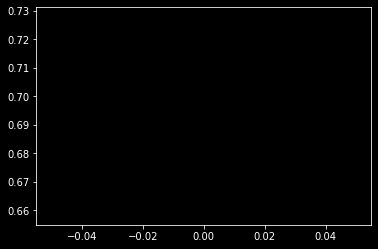

In [0]:
def NN_model(NN = [{"nodes": 0, "function": "identity"},
                   {"nodes": 1, "function": "sigmoid"}],
             X = numpy.array([[0, 1, 0, 1], [0, 0, 1, 1]]),
             y = numpy.array([0, 0, 0, 1]), rate = 0.0025, 
             iterations = 10, cost = "negative likelihood",
             batch_size = 0.05, reg = 0):
    """
    Generic neural network assembly and training procedure.
    Inputs: -> "NN": Neural network dict structure.
            -> "X": training samples' array.  | X's rows are variables,
            -> "y": training outcomes' array. | X & y's columns are samples.
            -> "iterations": Amount of parameter update cycles.
            -> "cost": string label/description of cost function to apply.
            -> "rate": Learning rate/gain. Must be a float number.
            -> "optimizer": string label/description of optimizer to apply.
    Output: -> "NN": Same dict but with updated weights and biases.
    """
    import sys
    # print("Progress:")
    NN = NN_init(NN = NN, X = X)
    sys.stdout.write("\r[%s] 0%%" % (" "*50))
    y = numpy.matrix(y)
    sys.stdout.flush()
    batches = numpy.arange(step = batch_size*y.size,
              start = 0, stop = y.size + 1, dtype = int)
    for iteration in range(1, iterations + 1):
        for batch in range(1, len(batches)):
            X_batch = X[:, batches[batch - 1] : batches[batch]]
            y_batch = y[:, batches[batch - 1] : batches[batch]]
            NN = f_propagate(NN = NN, X = X_batch)
            NN = b_propagate(NN = NN, y = y_batch, cost = cost, reg = reg)
            NN = learn(NN = NN, rate = rate)
            prog = (iteration + batch/len(batches))/iterations
            bar = "■"*int(50*prog) + " "*int(50*(1 - prog))
            sys.stdout.write("\r[%s] %d%%" % (bar, 100*prog - 1))
            sys.stdout.flush()

    print() ; return NN

############################################################### Model test.
v = X_2D_train.shape[0]
NN = [ {"nodes": v, "weights": 1,    "bias": 0,    "function": None},
       {"nodes": 4, "weights": None, "bias": None, "function": "tanh"},
       {"nodes": 1, "weights": None, "bias": None, "function": "sigmoid"} ]

NN = NN_model(NN = NN, X = X_2D_train, y = y_1D_train,
              iterations = 50, rate = 5.0, reg = 0)
matplotlib.pyplot.plot(NN[-1]["cost"][0])

## <ul><font color = "yellow" size = "4"><b><u>Test phase</u></b></font> ##

<ul>Predictions can now be made with the already trained model, executing a forward-propagation routine on a new "testing" dataset.
<br>What was before an output "$𝔸_{L}$" for further back-propagation, would now be just an estimation of the real outcome on such new input.
<br>Such output does indeed measure the probability of a certain output. In this example, the chances of a point "$s$" of being blue and not red.
<br>Therefore: "$p($point "s" is blue$)\;= a_{s}$" ... and ... "$p($point "s" is red$)\;= 1 - a_{s}$".

So one could just use these "$a_{s}$"and choose to take for granted that values whose probability is above a certain threshold "$a_{th}$" are blue.
<br>In cases where symmetry should be kept (like this one), it may be tempting to choose "$a_{th} = 0.5$" as threshold.
<br>In cases such as in trading strategies, there could be a certain risk associated with choosing a small threshold.
<br>Threshold values thus should be chosen according to the model requirements.

In [0]:
def predict(NN, X):
    """
    Test function. Just made to make model compatible with 'planar_utils.-
    -.plot_decision_boundary' and its need for "parameters" dict argument.
    """
    A = X
    parameters = {}
    for layer in range(1, len(NN)):
        W = NN[layer]["weights"]
        print(W.shape)
        parameters["W%d" % layer] = W
        b = NN[layer]["bias"]
        parameters["b%d" % layer] = b
        Z = b + dot(W, A)
        if NN[layer]["function"] == "relu": A = numpy.multiply(Z, Z > 0)
        if NN[layer]["function"] == "tanh": A = tanh(Z)
        if NN[layer]["function"] == "sigmoid": A = 1/(1 + exp(-Z))
        
    return (A > 0.5)

# Predict on sample data.
A_train = predict(NN, X_2D_train)
# Get unpredicted points.
print(A_train.shape)
y_miss = A_train[y_1D_train != A_train]*1
print("Missed samples: %d/%d" % (y_miss.size, A_train.size), " | ",
      "Training error: %.2f %%\n" % (100*y_miss.size/A_train.size))
planar_utils.plot_decision_boundary(lambda x: predict(NN, x),
                                    X_2D_train, y_1D_train)

<ul><b><u>Interpretation</u></b>:
<ul> <li>The larger models (with more hidden units) are able to fit the training set better.<br>Eventually, however, the largest models overfit the data. 
</li><li>The best hidden layer size seems to be of around 5 neurons.<br>Indeed, a value around here seems to fit the data well without also incurring noticable overfitting.
</li><li>You will also learn later about regularization, which lets you use very large models without much overfitting. 

In [0]:
# Datasets...
X1, X2, X3, X4, X5 = planar_utils.load_extra_datasets()
Dlabels = ["circles", "moons", "blobs", "quartiles"]
Dsets = dict(zip(Dlabels, [X1, X2, X3, X4]))
# Choose one...
dataset = "quartiles"
X_set, y_set = Dsets[dataset]
X_set, y_set = X_set.T, y_set.reshape(1, y_set.shape[0])
if dataset == "blobs": y_set = y_set % 2
# Train network.
v, n_samples = X_set.shape
NN_set = NN_model(
    NN = [{"nodes": v, "weights": 1,    "bias": 0,    "function": None},
          {"nodes": 4, "weights": None, "bias": None, "function": "tanh"},
          {"nodes": 1, "weights": None, "bias": None, "function": "sigmoid"}],
          X = X_set, y = y_set, iterations = 1000, rate = 5, reg = [-0.01, 2])
# Predict on sample data.
A_set = (NN_set[-1]["output"] > 0.5)*1 # Estimate.
# Get unpredicted points.
y_miss = A_set[y_set != A_set]*1
print("Missed samples: %d/%d" % (y_miss.size, A_set.size), " | ",
      "Training error: %.2f %%\n" % (100*y_miss.size/A_set.size))
planar_utils.plot_decision_boundary(lambda x: predict(NN_set, x), X_set, y_set)

<ul>References:
<ul> <li><a href = "http://scs.ryerson.ca/~aharley/neural-networks/">Ryerson - Neural Networks</a>
</li><li><a href = "http://cs231n.github.io/neural-networks-case-study/">Additional case studies</a>
</li></ul>